# ECON 522 Lab - Week 1

Today we will discuss the following. (1) How to model structural breaks with dummy variables, (2) How to model seasonality with dummy variables, and (3) Operationalizing the Chow's Test and the Quandt Test

## Using Dummies for Breaks

For our example on structural breaks, let us use the effective Federal Funds rate. As before, try and use the FRED API to download this.

            Federal Funds Rate
1954-07-01                0.80
1954-08-01                1.22
1954-09-01                1.07
1954-10-01                0.85
1954-11-01                0.83
...                        ...
2024-08-01                5.33
2024-09-01                5.13
2024-10-01                4.83
2024-11-01                4.64
2024-12-01                4.48

[846 rows x 1 columns]


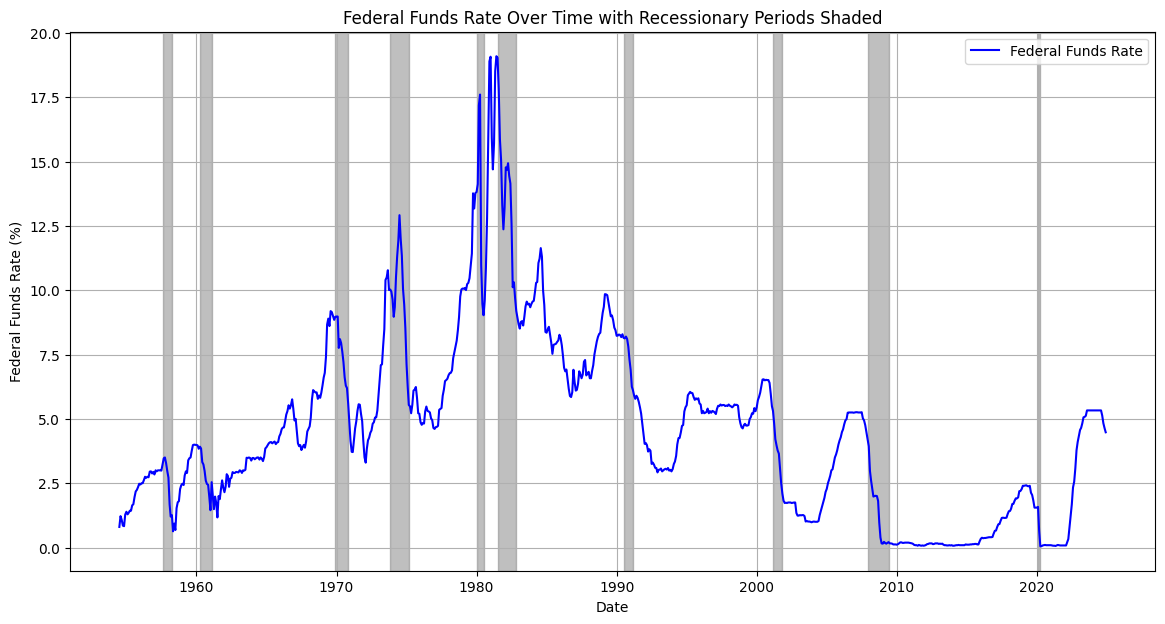

In [8]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key='fe3741e38a5245c3cc826f2d6ae3e1f2')

# Download the Federal Funds Rate series (FEDFUNDS) from FRED
# Use monthly data from as far back as possible to the current date
federal_funds_rate = fred.get_series('FEDFUNDS', observation_start='1954-07-01')

# Convert the series to a DataFrame
federal_funds_rate_df = federal_funds_rate.to_frame(name='Federal Funds Rate')
federal_funds_rate_df.index = pd.to_datetime(federal_funds_rate_df.index)
print(federal_funds_rate_df)


# Plot the Federal Funds Rate over time
plt.figure(figsize=(14, 7))
plt.plot(federal_funds_rate_df.index, federal_funds_rate_df['Federal Funds Rate'], label='Federal Funds Rate', color='blue')

# Shade recessionary periods
recession_periods = [
    ('1957-08-01', '1958-04-01'),
    ('1960-04-01', '1961-02-01'),
    ('1969-12-01', '1970-11-01'),
    ('1973-11-01', '1975-03-01'),
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01')
]

for start, end in recession_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.5)

plt.title('Federal Funds Rate Over Time with Recessionary Periods Shaded')
plt.xlabel('Date')
plt.ylabel('Federal Funds Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In the code above, I pretty much used AI to code up the graph and told it to shade the recessionary periods. Recessionary periods should NOT be confused for structural breaks but in practice, they are often good candidates since certain long lasting policies may be implemented to curb a recession

Let us test for the so called "Volker" shock. Let us generate a dummy variable that is 0 prior to January 1987 and 1 afterwards. We can even try and be more granular with the dummy by specifying a specific range but let us be more general for the moment. Read up on it here: https://www.statista.com/statistics/1338105/volcker-shock-interest-rates-unemployment-inflation/

In [9]:
federal_funds_rate_df['Volker'] = (federal_funds_rate_df.index >= '1987-01-01').astype(int)
print(federal_funds_rate_df)

            Federal Funds Rate  Volker
1954-07-01                0.80       0
1954-08-01                1.22       0
1954-09-01                1.07       0
1954-10-01                0.85       0
1954-11-01                0.83       0
...                        ...     ...
2024-08-01                5.33       1
2024-09-01                5.13       1
2024-10-01                4.83       1
2024-11-01                4.64       1
2024-12-01                4.48       1

[846 rows x 2 columns]


Let us take a simple model with deterministic trend incorporating the dummy variable. Clearly, before January 1987, $D_t = 0$ so $FFR_t = c + \beta t + u_t$. However, after January 1987, $D_t = 1$, so $FFR_t = c + \alpha D_t + \beta t + u_t$

In [10]:
import statsmodels.api as sm

# Create a time trend variable
federal_funds_rate_df['Trend'] = range(len(federal_funds_rate_df))

# Define the dependent variable (Federal Funds Rate)
y = federal_funds_rate_df['Federal Funds Rate']

# Define the independent variables (constant, trend, and Volker dummy)
X = sm.add_constant(federal_funds_rate_df[['Trend', 'Volker']])

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Federal Funds Rate   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     90.99
Date:                Tue, 21 Jan 2025   Prob (F-statistic):           1.67e-36
Time:                        14:03:26   Log-Likelihood:                -2193.3
No. Observations:                 846   AIC:                             4393.
Df Residuals:                     843   BIC:                             4407.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8846      0.240     24.475      0.0

We can clearly see that post Volker, interest rates have been consistently lower (evidenced by the negative and statistically significant relationship).

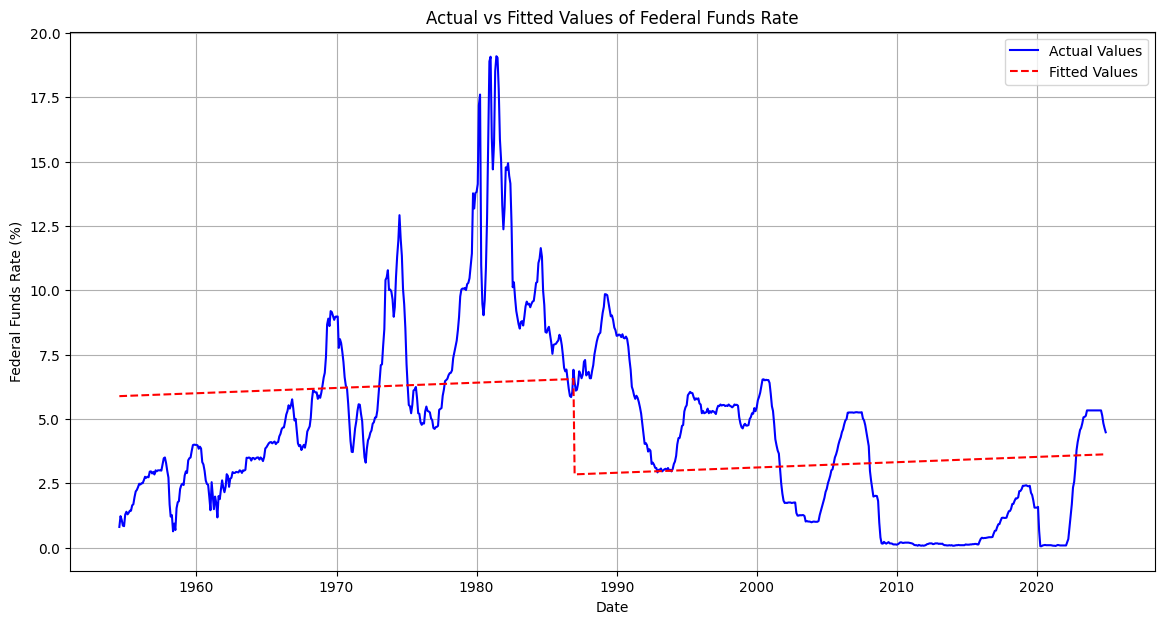

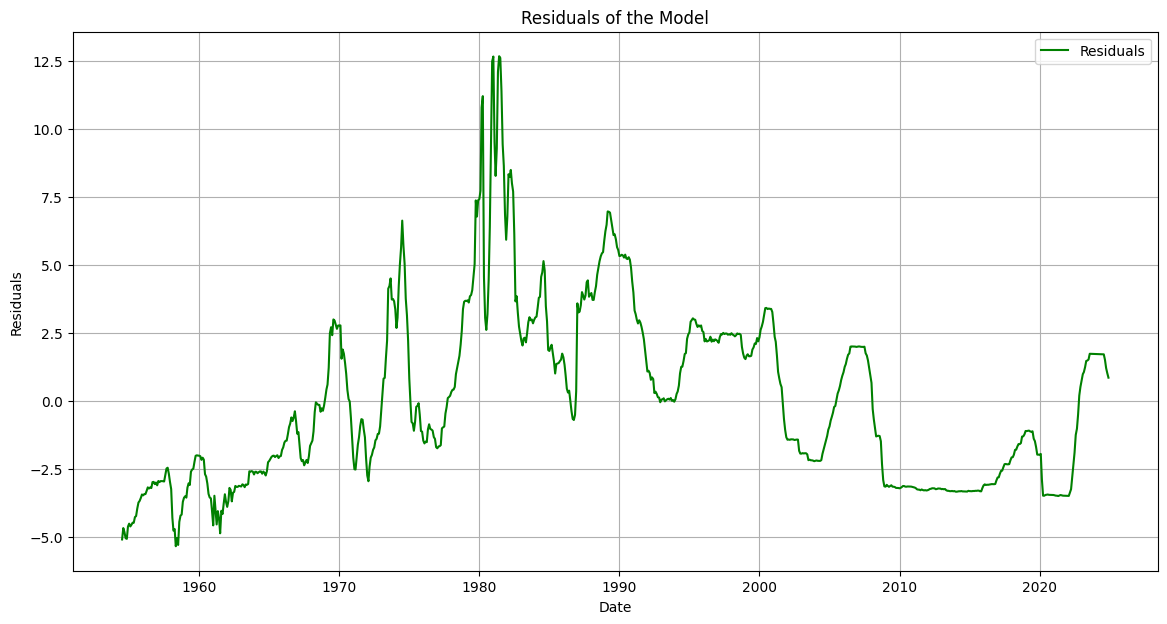

In [11]:
# Get the fitted values and residuals
fitted_values = model.fittedvalues
residuals = model.resid

# Plot the actual and fitted values
plt.figure(figsize=(14, 7))
plt.plot(federal_funds_rate_df.index, y, label='Actual Values', color='blue')
plt.plot(federal_funds_rate_df.index, fitted_values, label='Fitted Values', color='red', linestyle='--')
plt.title('Actual vs Fitted Values of Federal Funds Rate')
plt.xlabel('Date')
plt.ylabel('Federal Funds Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the residuals
plt.figure(figsize=(14, 7))
plt.plot(federal_funds_rate_df.index, residuals, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

## Using Dummies for Seasonality

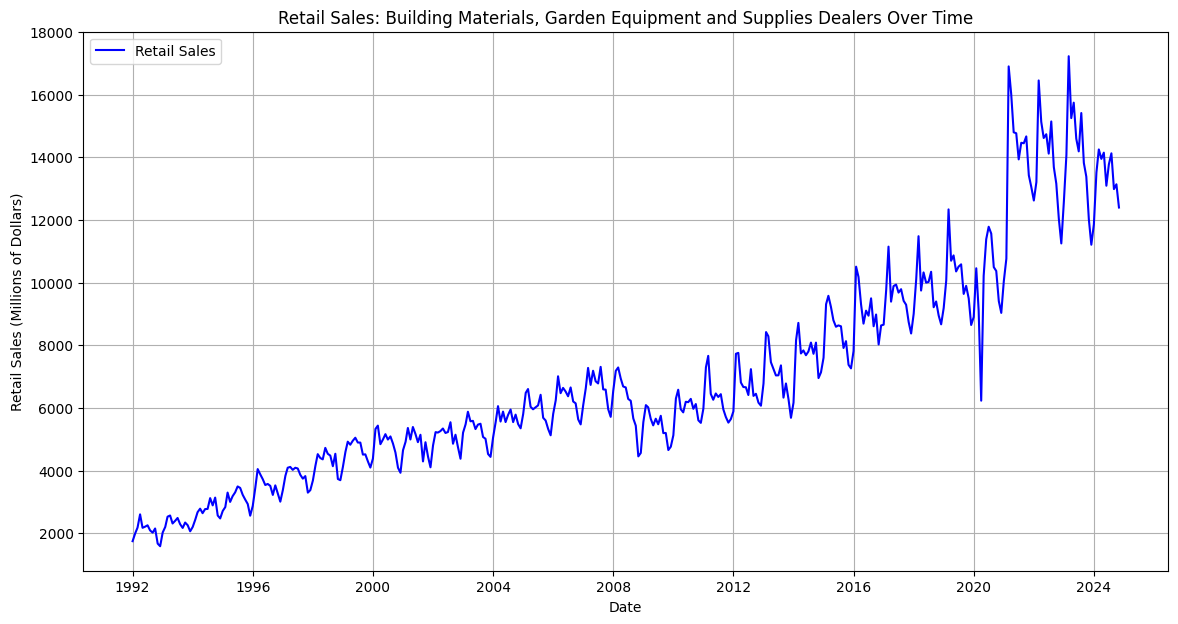

In [19]:
# Download the MRTSSM44112USN series (Retail Sales: Building Materials, Garden Equipment and Supplies Dealers) from FRED
retail_sales = fred.get_series('MRTSSM44112USN', observation_start='1992-01-01')

# Convert the series to a DataFrame
retail_sales_df = retail_sales.to_frame(name='Retail Sales')
retail_sales_df.index = pd.to_datetime(retail_sales_df.index)

# Plot the Retail Sales over time
plt.figure(figsize=(14, 7))
plt.plot(retail_sales_df.index, retail_sales_df['Retail Sales'], label='Retail Sales', color='blue')
plt.title('Retail Sales: Building Materials, Garden Equipment and Supplies Dealers Over Time')
plt.xlabel('Date')
plt.ylabel('Retail Sales (Millions of Dollars)')
plt.legend()
plt.grid(True)
plt.show()


Now, let us generate some dummy variables. Assume for the moment we think there is quarterly seasonality. Typically, one would expect that Q1 would be very strong since people get money in Q4 and spend in Q1

In [21]:
# Generate Q1, Q2, and Q3 variables
retail_sales_df['Q1'] = retail_sales_df.index.month.isin([1, 2, 3]).astype(int)
retail_sales_df['Q2'] = retail_sales_df.index.month.isin([4, 5, 6]).astype(int)
retail_sales_df['Q3'] = retail_sales_df.index.month.isin([7, 8, 9]).astype(int)
retail_sales_df['Q4'] = retail_sales_df.index.month.isin([10, 11, 12]).astype(int)
print(retail_sales_df[['Q1', 'Q2', 'Q3','Q4']])

            Q1  Q2  Q3  Q4
1992-01-01   1   0   0   0
1992-02-01   1   0   0   0
1992-03-01   1   0   0   0
1992-04-01   0   1   0   0
1992-05-01   0   1   0   0
...         ..  ..  ..  ..
2024-07-01   0   0   1   0
2024-08-01   0   0   1   0
2024-09-01   0   0   1   0
2024-10-01   0   0   0   1
2024-11-01   0   0   0   1

[395 rows x 4 columns]


In [23]:
# Generate the first lag of Retail Sales
retail_sales_df['Lag_Retail_Sales'] = retail_sales_df['Retail Sales'].shift(1)

# Drop the first row with NaN value in Lag_Retail_Sales
retail_sales_df = retail_sales_df.dropna()

# Redefine the dependent and independent variables
y_retail = retail_sales_df['Retail Sales']
X_retail = sm.add_constant(retail_sales_df[['Q2', 'Q3', 'Q4', 'Lag_Retail_Sales']])

# Fit the OLS model
model_retail = sm.OLS(y_retail, X_retail).fit()

# Print the summary of the regression results
print(model_retail.summary())

                            OLS Regression Results                            
Dep. Variable:           Retail Sales   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     2608.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):          2.26e-279
Time:                        11:17:30   Log-Likelihood:                -3107.5
No. Observations:                 394   AIC:                             6225.
Df Residuals:                     389   BIC:                             6245.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              807.3619     90.140  